# Training

Erik S. McGuire

CSC594-810-ADL, Winter 19-20

---
## I. Preliminaries
 > A. Imports\*

 > B. Data

---

 *<small>Required.</small>

### A. Imports
* Mount and navigate to Google Drive, import dependencies.

* Training in this notebook was mostly done on free tier GPU runtime with standard RAM.

> Mount drive if not automatically done when runtime reactivated (can also use sidepanel to the left):

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

> Install and import HuggingFace Transformers as our main library for training and generation with GPT-2.

In [ ]:
#Required over !pip install transformers for subclassing model/overriding methods.
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install .
%cd ..
from IPython.display import clear_output
clear_output()

In [ ]:
%tensorflow_version 2.x
from transformers import GPT2Tokenizer, GPT2DoubleHeadsModel, GPT2LMHeadModel, PreTrainedModel

In [ ]:
%cd drive/My Drive/csc594-ADL

> Import necessary modules and tools for data manipulation and interface:

In [ ]:
import string, csv, re, random, logging, torch, io
from string import punctuation as punk
from ipywidgets import *
import torch.nn.functional as F 
import pandas as pd
import numpy as np

> When Transformers installed in root, we must navigate to main project folder in mounted My Drive. 

> Assumes the following structure:
<pre>.
├── content
│   ├──drive                         # Mounted drive folder.
│   │   └── My Drive                 # Mounted drive folder.
│   │       └── CSC-594-ADL          # Main project folder.
│   │           ├── datasets         # ConceptNet and ROCStories.
│   │           ├── endings          # Correct and generated endings per model.
│   │           ├── evals            # Evaluation results for stories and endings per model.
│   │           ├── models           # Pretrained models, tokenizers, vocabulary, etc.
│   │           ├── scripts          # Scripts for training and generation.
│   │           └── stories          # Combined story bodies and generated endings per model.
│   ├── sample_data                  # Default Colab folder.
│   └── transformers                 # Installed from HuggingFace.
└── ...
</pre>

### B. Data
* Create/write data necessary for language modeling.
* Not necessary to run this, as data has been created.

Create and write to train/val/test .txts via generated ConceptNet sentences and ROCStories unlabeled training data:

In [ ]:
def create_train_test(filename: str = None, lines: list = None) -> None:
    """Create train/val/test txts from list of lines from file."""
    held_out_lines = []
    test_lines = set()
    
    # Get lines to create dev, test sets.
    n = len(lines) * 0.005
    for idx in range(len(lines)):
        line = random.choice(lines)
        if len(held_out_lines) <= n:
            held_out_lines.append(line)
            lines.remove(line)

    # Test set, leave remainder for validation.
    hn = len(held_out_lines) * 0.5
    for idx in range(len(held_out_lines)):
        hline = random.choice(held_out_lines)
        if len(test_lines) <= hn:
            test_lines.add(re.sub("_sep_", ",", hline))
            held_out_lines.remove(hline)

    # Assumes we are in main project folder.
    with open(f'datasets/{filename}_train.txt', 'w') as train_file:
        train_file.write(re.sub("_sep_", "", "".join(lines)))
    with open(f'datasets/{filename}_val.txt', 'w') as val_file:
        val_file.write(re.sub("_sep_", "", "".join(held_out_lines)))
    with open(f'datasets/{filename}_test.txt', 'w') as test_file:
        test_file.write("".join(list(test_lines)))
        
def create_data(typ: str):
    """Create and write train/val/test .txts."""

    def get_roc(roc_file: str) -> list:
        """Obtain stories, endings from ROC training files."""
        roc_df = pd.read_csv(roc_file, sep=',')
        roc_df['split'] = np.random.randn(roc_df.shape[0], 1)
        mask = np.random.rand(len(roc_df)) <= 0.95
        train = roc_df[mask]
        held_out = roc_df[~mask]
        hmask = np.random.rand(len(held_out)) <= 0.5
        val = held_out[hmask]
        test = held_out[~hmask]
        filename = roc_file.replace(".csv", "")
        train.to_csv(f'{filename}_train.txt', header=None, index=False)
        val.to_csv(f'{filename}_val.txt', header=None, index=False)
        test.to_csv(f'{filename}_test.csv', index=False)

    if typ == "ROC":
        roc2016 = 'datasets/ROCStoriesSpring2016.csv'
        roc2017 = 'datasets/ROCStoriesWinter2017.csv'
        df_16 = pd.read_csv(roc2016, sep=',')
        df_17 = pd.read_csv(roc2017, sep=',')
        df_167 = df_16.append(df_17)
        df_167.to_csv('roc_1617.csv', index=False)
        get_roc('roc_1617.csv')

    elif typ == "ConceptNet":
        cn_file = 'datasets/sentences_train600k.txt'
        with open(cn_file) as cn_train:
            cn_lines = cn_train.read().splitlines()
            for ix, line in enumerate(cn_lines):
                line += "\n"
                cn_lines[ix] = line
        create_train_test("conceptnet", cn_lines)

Select data to create/write:

In [ ]:
create_inter = interactive(create_data, 
                           {'manual': True, 
                            'manual_name': 'Create/write data'}, 
                           typ=RadioButtons(options=['ROC', 
                                                     'ConceptNet'], 
                                            description='Source type'))
display(create_inter)

---
## II. Training
> A.Language Modeling

> B. Multi-task Fine-tuning
---

### A. Language Modeling

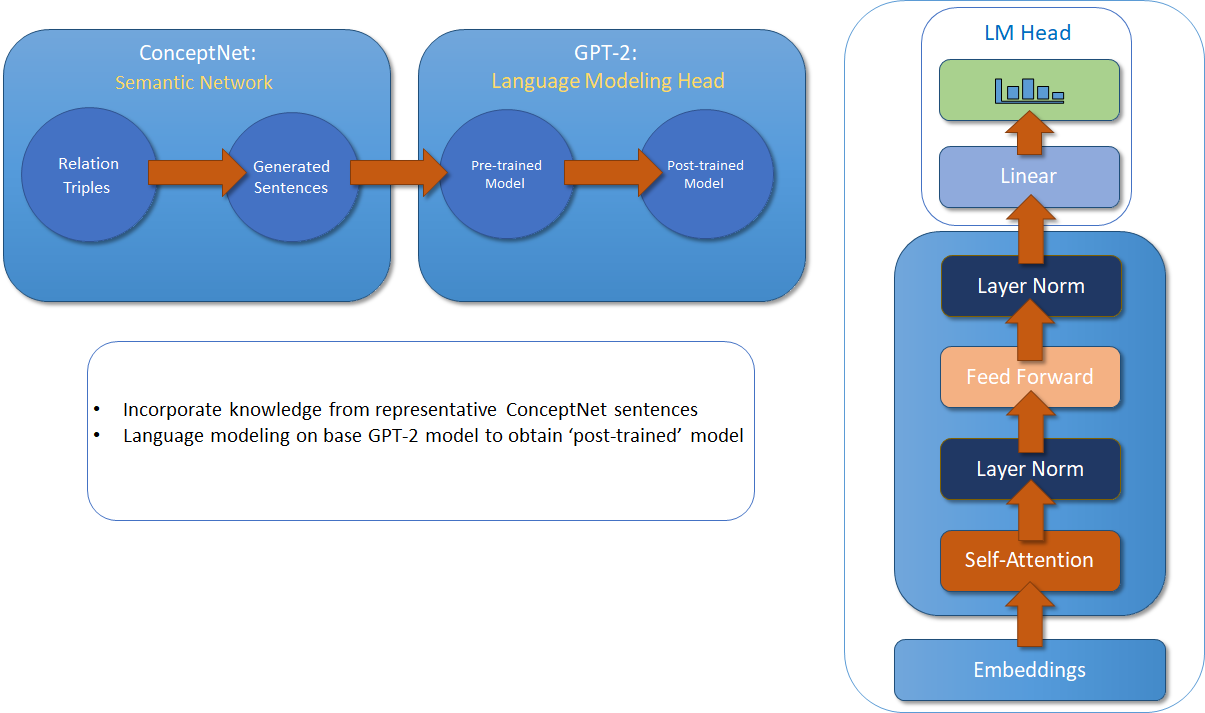

#### Arguments LM
* Define, display classes, model pipelines for language modeling script arguments.

##### Define LM args

In [ ]:
class LM():
    """Class to perform single head LM on ConceptNet and/or ROCStories."""

    def __init__(self, typ='', do_train='', 
                            output_dir=None, 
                            n_or_p='gpt2', 
                            overwrite=''):
        self.typ = typ
        self.do_train = do_train
        self.do_eval = '--do_eval'
        self.overwrite_output_dir = overwrite
        self.per_gpu_train_batch_size = '--per_gpu_train_batch_size=2'
        self.model_type = f'--model_type=models/{n_or_p}'
        if typ == 'ConceptNet' or typ == 'cn':
            self.typ = "ConceptNet"
            if not output_dir:
                output_dir = '--output_dir=models/conceptnet'
            self.output_dir = output_dir
            self.model_name_or_path = n_or_p
            self.train_data_file = '--train_data_file=datasets/conceptnet_train.txt'
            self.eval_data_file = '--eval_data_file=datasets/conceptnet_val.txt'
        elif typ.lower() == 'roc':
            self.typ = "ROC"
            if not output_dir:
                output_dir = '--output_dir=models/roc1617'
            self.output_dir = output_dir
            self.model_name_or_path = n_or_p
            self.train_data_file = '--train_data_file=datasets/roc_1617_train.txt'
            self.eval_data_file = '--eval_data_file=datasets/roc_1617_val.txt'
    
    def __str__(self):
        """Pretty print attributes."""
        return "\n".join([
            "Type: " + self.typ,
            self.output_dir,
            self.model_type,
            self.model_name_or_path,
            '--do_train == ' + str(bool(self.do_train)),
            self.train_data_file,
            '--do_eval == ' + str(bool(self.do_eval)),
            self.eval_data_file,
            self.per_gpu_train_batch_size,
            self.overwrite_output_dir])
        
    def run_lm(self):
        """Run LM training script."""
        !python scripts/run_language_modeling.py \
            {self.output_dir} \
            {self.model_type} \
            {self.model_name_or_path} \
            {self.do_train} \
            {self.train_data_file} \
            {self.do_eval} \
            {self.eval_data_file} \
            {self.per_gpu_train_batch_size} \
            {self.overwrite_output_dir}

def get_LM_args(typ: str, 
            do_train='',
            output_dir=None,
            n_or_p='gpt2',
            overwrite='',
            show = True) -> list:
        """Instantiate language modeling argument class."""
        do_train = do_train
        overwrite_output_dir = overwrite
        if output_dir == 'May leave blank.':
            output_dir = None
        if typ == 'cn' or typ == 'ConceptNet':
            if not output_dir:
                output_dir = 'conceptnet'
            output_dir = f'--output_dir=models/{output_dir}'
            n_or_p = f'--model_name_or_path={n_or_p}'
        elif typ.lower() == 'roc':
            if not output_dir:
                output_dir = 'roc1617'
            output_dir = f'--output_dir=models/{output_dir}'
            n_or_p = f'--model_name_or_path={n_or_p}'
        args_LM = LM(typ, do_train, output_dir, n_or_p, overwrite)
        if show:
            print("Results:\n", args_LM)
        return args_LM

def call_get_LM_args(pipeline: str, do_train, overwrite, show: bool = True) -> list:
    """Choose pipeline to get args."""
    if pipeline == 'ConceptNet':
        return get_LM_args(typ='cn', 
                           do_train=do_train,
                           overwrite=overwrite,
                           show=show)
    if pipeline == 'ROCStories':
        return get_LM_args(typ='roc', 
                           do_train=do_train,
                           overwrite=overwrite,
                           show=show)
    if pipeline == 'ROC to ConceptNet':
        return get_LM_args('cn', 
                            output_dir='b_roc_cn',
                            n_or_p='models/roc1617',
                            do_train=do_train,
                            overwrite=overwrite,
                            show=show)
    if pipeline == 'ConceptNet to ROC':
        return get_LM_args('roc', 
                            output_dir='b_cn_roc',
                            n_or_p='models/conceptnet',
                            do_train=do_train,
                            overwrite=overwrite,
                            show=show)

##### Select LM pipeline

In [ ]:
pipe_disp = interactive(call_get_LM_args, 
                        pipeline=['ConceptNet', 
                                  'ROCStories',
                                  'ROC to ConceptNet',
                                  'ConceptNet to ROC'],
                        do_train=[('False (eval only)', ''), ('True', '--do_train')],
                        overwrite=[('False (don\'t overwrite out dir)', ''),
                                   ('True', '--overwrite_output_dir')],
                        show=[('Show args', True), ('Don\'t show args', False)])
pipe_disp.layout.height = '350px'
display(pipe_disp)

In [ ]:
if pipe_disp.result:
    args_LM = pipe_disp.result

---
##### Run LM with arguments:

In [ ]:
args_LM.run_lm()

---
### B. Multi-task Fine-tuning
* Define, display classes, model pipelines for MTL fine-tuning script arguments.

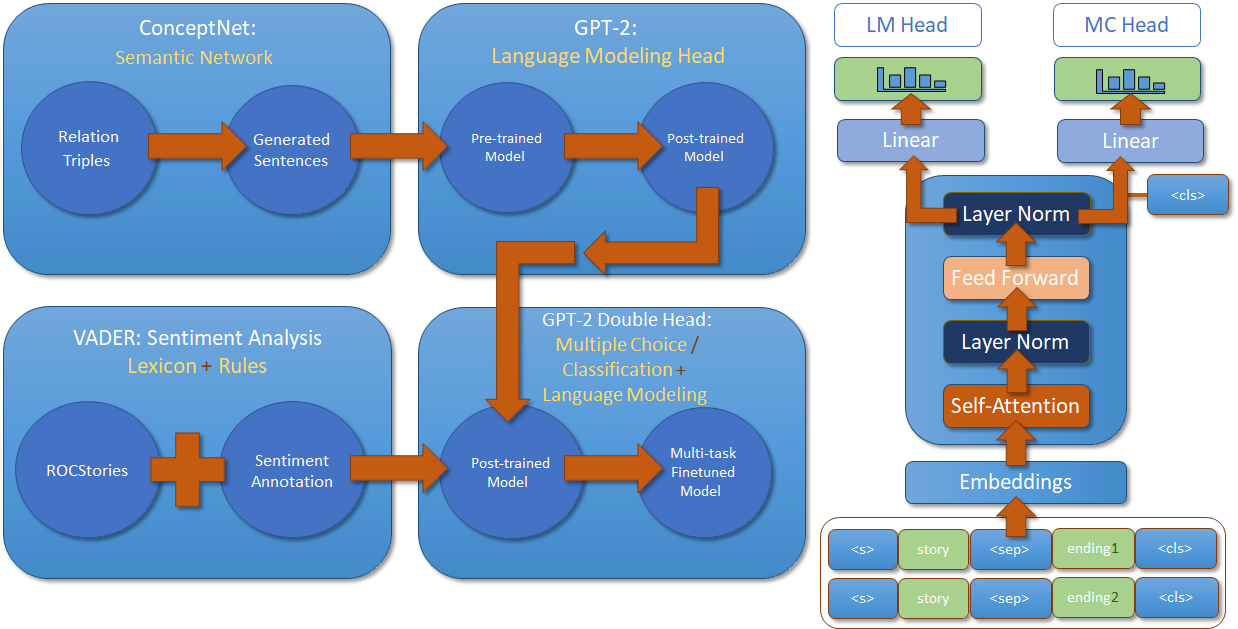

#### Arguments MTL
* Define, display classes, model pipelines for multitask finetuning script arguments.

##### Define MTL args

In [ ]:
class MTL():
    """Class to perform MTL fine-tuning on SCT/Sentiment tasks."""

    def __init__(self, typ = 'SCT', do_train='', 
                            output_dir=None, 
                            model_name=None,
                            lm_coef=0.5,
                            mc_coef=1.0):
        self.typ = typ
        self.do_train = do_train
        self.do_eval = '--do_eval'
        self.train_batch_size = '--train_batch_size=16'
        self.output_dir = f'--output_dir=models/{output_dir}'
        self.lm_coef=lm_coef
        self.mc_coef=mc_coef
        if model_name:
            self.model_name = f'--model_name=models/{model_name}'
        else:
            self.model_name = '--model_name=gpt2'
        if typ.lower() == 'sentiment':
            self.train_dataset = '--train_dataset=datasets/roc2018sentival.csv' # Labels based on sentiment congruity.
            self.eval_dataset = '--eval_dataset=datasets/roc2016sentitest.csv'
        else: # default Story Cloze Task (SCT)
            self.train_dataset = '--train_dataset=datasets/roc2018val.csv' # Original ROC test data, not LM test data.
            self.eval_dataset = '--eval_dataset=datasets/roc2016test.csv' # Original val data, not LM val data.

    def __str__(self):
        """Pretty print attributes."""
        return "\n".join([
            "Type: " + self.typ,
            self.model_name,
            '--do_eval == ' + str(bool(self.do_eval)),
            '--do_train == ' + str(bool(self.do_train)),
            self.train_dataset,
            self.eval_dataset,
            self.output_dir,
            self.lm_coef,
            self.mc_coef,
            self.train_batch_size])
        
    def run_mtl(self):
        """Run MTL finetuning script."""
        !python scripts/run_mtl.py \
            {self.model_name} \
            {self.do_eval} \
            {self.do_train} \
            {self.train_dataset} \
            {self.eval_dataset} \
            {self.output_dir} \
            {self.lm_coef} \
            {self.mc_coef} \
            {self.train_batch_size}

def get_MTL_args(typ: str, 
            do_train='',
            output_dir=None,
            model_name='',
            show = True,
            lm_coef: float = 0.5,
            mc_coef: float = 1.0) -> list:
        """Instantiate finetuning argument class."""
        do_train = do_train
        lm_coef = f'--lm_coef={lm_coef}'
        mc_coef = f'--mc_coef={mc_coef}'
        if output_dir == 'May leave blank.':
            output_dir = None
        if typ == 'cn' or typ == 'ConceptNet':
            if not output_dir:
                output_dir = f'conceptnet_{typ}'
            output_dir = f'--output_dir=models/{output_dir}'
            model_name = f'--model_name={model_name}'
        elif typ.lower() == 'roc':
            if not output_dir:
                output_dir = f'roc1617_{typ}'
            output_dir = f'--output_dir=models/{output_dir}'
            model_name = f'--model_name={model_name}'
        args_MTL = MTL(typ, do_train, output_dir, model_name, lm_coef, mc_coef)
        if show:
            print("Results:\n", args_MTL)
        return args_MTL

def call_get_MTL_args(pipeline: str, do_train, show: bool, lm_coef: float, mc_coef: float) -> list:
    """Choose pipeline to get args."""
    typ = 'SCT'
    model_name = ''
    output_dir = 'gpt2'
    if pipeline.startswith('Base'):
        # pipeline == 'Base' by default
        if pipeline == 'Base to SCT':
            model_name = 'gpt2'
            output_dir='b_SCT'
        elif pipeline == 'Base to SCT to Sentiment':
            typ='Sentiment'
            model_name = 'b_SCT'
            output_dir='b_SCT_sentiment'
        elif pipeline == 'Base to Sentiment':
            typ='Sentiment'
            model_name = 'gpt2'
            output_dir='b_sentiment'
        elif pipeline == 'Base to Sentiment to SCT':
            model_name='b_sentiment'
            output_dir='b_sentiment_SCT'
    if 'ConceptNet' or 'CN' in pipeline:
        if pipeline == 'ConceptNet to SCT':
            model_name='conceptnet'
            output_dir='cn_SCT'
        elif pipeline == 'ConceptNet to Sentiment':
            typ='Sentiment'
            model_name='conceptnet'
            output_dir='cn_sentiment'
        elif pipeline == 'ConceptNet to ROC to Sentiment':
            typ='Sentiment'
            model_name='cn_roc'
            output_dir='cn_roc_sentiment'
        elif pipeline == 'CN to ROC to Sentiment to SCT':
            model_name='cn_roc_sentiment'
            output_dir='cn_roc_sentiment_SCT'
        elif pipeline == 'ConceptNet to ROC to SCT':
            model_name='cn_roc'
            output_dir='cn_roc_SCT'
        elif pipeline == 'CN to ROC to SCT to Sentiment':
            typ='Sentiment'
            model_name='cn_roc_SCT'
            output_dir='cn_roc_SCT_sentiment'
        elif pipeline == 'CN to SCT to Sentiment':
            typ='Sentiment'
            model_name='cn_SCT'
            output_dir='cn_SCT_sentiment'
        elif pipeline == 'CN to Sentiment to SCT':
            model_name='cn_sentiment'
            output_dir='cn_sentiment_SCT'
    if pipeline.startswith('ROC'):
        if pipeline == 'ROC to SCT': 
            model_name='roc1617'
            output_dir='roc1617_SCT'
        elif pipeline == 'ROC to SCT to Sentiment':
            typ='Sentiment'
            model_name='roc1617_SCT'
            output_dir='roc1617_SCT_sentiment'
        elif pipeline == 'ROC to Sentiment': 
            typ='Sentiment'
            model_name='roc1617'
            output_dir='roc1617_sentiment'
        elif pipeline == 'ROC to CN to Sentiment':
            typ='Sentiment'
            model_name='roc_cn'
            output_dir='roc_cn_sentiment'
        elif pipeline == 'ROC to Sentiment to SCT':
            model_name='roc1617_sentiment'
            output_dir='roc1617_sentiment_SCT'
        elif pipeline == 'ROC to CN to SCT':
            model_name='roc_cn'
            output_dir='roc_cn_sct'
        elif pipeline == 'ROC to CN to SCT to Sentiment':
            typ='Sentiment'
            model_name='roc_cn_sct'
            output_dir='roc_cn_sct_sentiment'
        elif pipeline == 'ROC to CN to Sentiment to SCT':
            model_name='roc_cn_sentiment'
            output_dir='roc_cn_sentiment_sct'
    return get_MTL_args(typ=typ,
                        model_name=model_name,
                        output_dir=output_dir,
                        do_train=do_train,
                        lm_coef=lm_coef,
                        mc_coef=mc_coef,
                        show=show)

##### Select MTL pipeline

In [ ]:
pipe_disp_MTL = interactive(call_get_MTL_args, 
                        pipeline=['Base to SCT',
                                  'Base to Sentiment',
                                  'Base to SCT to Sentiment',
                                  'Base to Sentiment to SCT',
                                  'ConceptNet to SCT', 
                                  'ConceptNet to Sentiment',
                                  'CN to SCT to Sentiment',
                                  'CN to Sentiment to SCT',
                                  'ConceptNet to ROC to SCT',
                                  'ConceptNet to ROC to Sentiment',
                                  'CN to ROC to SCT to Sentiment',
                                  'CN to ROC to Sentiment to SCT',
                                  'ROC to SCT',
                                  'ROC to Sentiment',
                                  'ROC to Sentiment to SCT',
                                  'ROC to SCT to Sentiment',
                                  'ROC to CN to SCT',
                                  'ROC to CN to SCT to Sentiment',
                                  'ROC to CN to Sentiment',
                                  'ROC to CN to Sentiment to SCT'],
                        do_train=[('False (eval only)', ''), ('True', '--do_train')],
                        show=[('Show args', True), ('Don\'t show args', False)],
                        lm_coef=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1),
                        mc_coef=FloatSlider(value=1.0, min=0.0, max=4.0, step=0.1),)
pipe_disp_MTL.layout.height = '400px'
display(pipe_disp_MTL)

interactive(children=(Dropdown(description='pipeline', options=('Base to SCT', 'Base to Sentiment', 'Base to S…

In [ ]:
if pipe_disp_MTL.result:
    args_MTL = pipe_disp_MTL.result

---
##### Run MTL with arguments:

In [ ]:
args_MTL.run_mtl()